In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4

mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

In [82]:
SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4

In [83]:
walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000

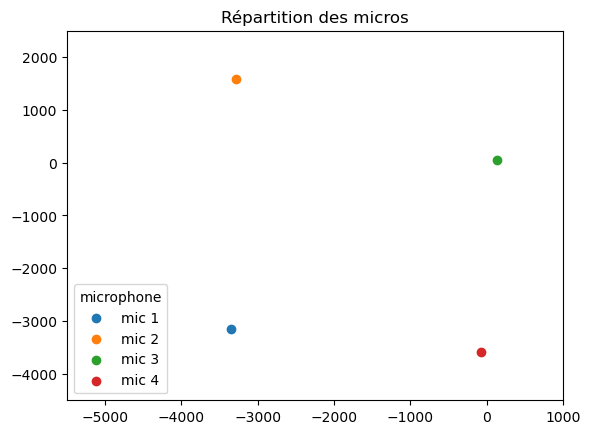

In [84]:
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

In [85]:
rirs_1 = np.load('../hackathon-minarm-2024/data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rirs_2 = np.load('../hackathon-minarm-2024/data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
rirs = np.append(rirs_1, rirs_2, axis=0)

In [86]:
localisations_1 = np.load('../hackathon-minarm-2024/data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
localisations_2 = np.load('../hackathon-minarm-2024/data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
localisations = np.append(localisations_1, localisations_2, axis=0)

In [87]:
print(rirs.shape)
print(localisations.shape)
N_datapoints, N_mics, N_samples = rirs.shape
print(N_samples)

(1104, 4, 667200)
(1104, 2)
667200


In [88]:
rms = np.sqrt(np.square(rirs).mean(axis=2))

In [89]:
print(rms)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.00051298 0.00049805 0.00068633 0.00042337]
 [0.00051482 0.00048913 0.00068826 0.00042545]
 [0.00051369 0.00049861 0.00069317 0.00042304]]


In [104]:
def distance(actual, expected):
    diff_x = actual[:, 0] - expected[:, 0]
    diff_y = actual[:, 1] - expected[:, 1]
    return np.sqrt(np.square(diff_x) + np.square(diff_y))

def mean_distance(actual, expected):
    return distance(actual, expected.to_numpy()).mean()

In [91]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(rms)
y = pd.DataFrame(localisations)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

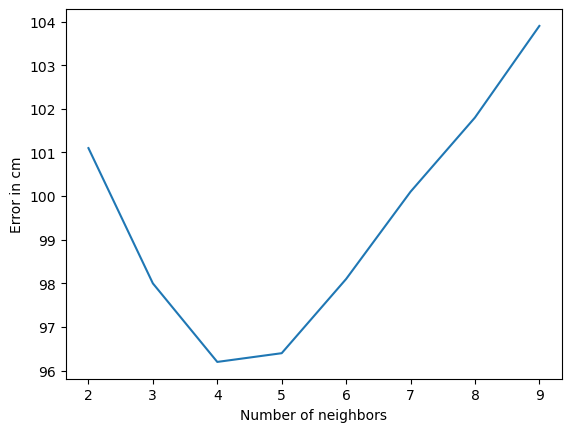

In [130]:
from sklearn.neighbors import KNeighborsRegressor

nb_neighbors = []
mean_distance_list = []
for i in range(2, 10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    nb_neighbors.append(i)
    mean_distance_list.append(round(mean_distance(knn.predict(X_test), y_test), 0) / 10)
plt.xlabel("Number of neighbors")
plt.ylabel("Error in cm")
plt.plot(nb_neighbors, mean_distance_list)
plt.show()

In [125]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
print(f"score: {knn.score(X_test, y_test)}")
print(f"distance moyenne: {round(mean_distance(knn.predict(X_test), y_test), 0) / 10} cm")

score: 0.46919474541537326
distance moyenne: 96.4 cm


In [114]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"score: {reg.score(X_test, y_test)}")
print(f"distance moyenne: {round(mean_distance(reg.predict(X_test), y_test), 0) / 10} cm")

score: 0.13984136122161933
distance moyenne: 149.5 cm
